In [76]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import tqdm

In [77]:
###############################################################################
# 주어진 결과와 정확히 비교하기 위한 random seed 고정
###############################################################################

seed = 0  # 바꾸지 마시오!
random.seed(seed)
np.random.seed(seed)

# Data pre-processing

In [78]:
base_path = os.path.join(os.curdir, '/opt/ml/input/data/train')
data_path = os.path.join(base_path, 'train_ratings.csv')
genre_path = os.path.join(base_path, "genres.tsv")
writer_path = os.path.join(base_path, "writers.tsv")
director_path = os.path.join(base_path, "directors.tsv")
director_path

'/opt/ml/input/data/train/directors.tsv'

### Rating Data

In [79]:
# 평점 데이터
ratings_df = pd.read_csv(data_path)
print(f'ratings_df의 shape {ratings_df.shape}')
ratings_df.columns = ['user', 'item', 'time']
ratings_df=ratings_df.drop(columns=['time'])
ratings_df['rating']=1 # 상호작용이 있기 때문에 1로 넣는다
ratings_df.head(5)

ratings_df의 shape (5154471, 3)


,user,item,rating
0,11,4643,1
1,11,170,1
2,11,531,1
3,11,616,1
4,11,2140,1


### num_negative 만큼의 neg sample

In [80]:
def neg_sample(rating_df, num_negative):
    #-- Negative instance 생성
    print(f"[INFO] Create Nagetive instances")
    
    items = set(rating_df.loc[:, 'item'])
    user_group_dfs = list(rating_df.groupby('user')['item'])
    
    user_neg_dfs = np.array([]).reshape(0, 3)

    for u, user_seen_list in user_group_dfs:
        
        #-- User가 시청한 영화 집합
        user_seen_set = set(user_seen_list)
        
        #-- 시청한 영화를 제외한 num_negative개의 영화 선택
        i_user_neg_item = np.random.choice(list(items - user_seen_set), num_negative, replace=False)
        
        #-- negative sample item's rating = 0
        neg_users = np.full(num_negative, u)
        neg_ratings = np.zeros(num_negative)
        
        #-- user u 에 대한 negative sample 결과 생성 : ["neg_user", "neg_item", "neg_rate"]
        neg_results = np.vstack((neg_users, i_user_neg_item, neg_ratings)).T
        user_neg_dfs = np.vstack((user_neg_dfs, neg_results))
    
    neg_rating_df = pd.DataFrame(data=user_neg_dfs, columns=["user", "item", "rating"])
    rating_df = pd.concat([rating_df, neg_rating_df], axis=0, sort=False)
    
    return rating_df

In [ ]:
NUM_NEGATIVE=50
print(f'(Before) {ratings_df.shape}')
ratings_df=neg_sample(ratings_df,NUM_NEGATIVE) # 5분 이하 소요
print(f'(After) {ratings_df.shape}')
ratings_df.head()

(Before) (5217191, 3)
[INFO] Create Nagetive instances
(After) (6785191, 3)


,user,item,rating
0,11.0,4643.0,1.0
1,11.0,170.0,1.0
2,11.0,531.0,1.0
3,11.0,616.0,1.0
4,11.0,2140.0,1.0


### Genre Data

In [81]:
# 장르 데이터
genre_df = pd.read_csv(genre_path,delimiter="\t")
genre_list=genre_df.loc[:,'genre'].to_numpy()
genre_list=np.unique(genre_list)
print(genre_df.head(5))
print("장르 종류 : ", genre_list)

item2onegenre=dict()
for i in range(len(genre_list)):
    item2onegenre[genre_list[i]]=i
print("장르->카테고리 숫자 : ",item2onegenre) # 장르 카테고리화

for i in range(len(genre_df)):
    genre_df.loc[i,'genre']=item2onegenre[genre_df.loc[i,'genre']]
genre_df.head()

   item     genre
0   318     Crime
1   318     Drama
2  2571    Action
3  2571    Sci-Fi
4  2571  Thriller
장르 종류 :  ['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']
장르->카테고리 숫자 :  {'Action': 0, 'Adventure': 1, 'Animation': 2, 'Children': 3, 'Comedy': 4, 'Crime': 5, 'Documentary': 6, 'Drama': 7, 'Fantasy': 8, 'Film-Noir': 9, 'Horror': 10, 'Musical': 11, 'Mystery': 12, 'Romance': 13, 'Sci-Fi': 14, 'Thriller': 15, 'War': 16, 'Western': 17}


,item,genre
0,318,5
1,318,7
2,2571,0
3,2571,14
4,2571,15


In [82]:
# 장르 1개 데이터
item_list=genre_df.loc[:,'item'].to_numpy()
item_list=np.unique(item_list)
print('길이 : ',len(item_list),item_list[-10:])

one_genre_list=[]
for i in item_list:
    temp=genre_df[genre_df.loc[:,'item']==i]
    one_genre_list.append(temp.iloc[0,:].to_numpy().tolist())
one_genre_df=pd.DataFrame(data=one_genre_list,columns=['item','genre'])
one_genre_df.head(5)

길이 :  6807 [116823 117176 117533 117881 118696 118700 118900 118997 119141 119145]


,item,genre
0,1,1
1,2,1
2,3,4
3,4,4
4,5,4


### Writer Data

In [83]:
# 작가 데이터
writer_df = pd.read_csv(writer_path,delimiter="\t")
print(f'writer_df의 shape {writer_df.shape}') #전체 
print(writer_df.head())
writer_list=writer_df.loc[:,'writer'].to_numpy()
writer_list=np.unique(writer_list)
print('unique한 writer_list길이 : ',len(writer_list),writer_list[-10:])

# 작가 1명만 데이터
item_list=writer_df.loc[:,'item'].to_numpy()
item_list=np.unique(item_list)
print('item_list 길이 : ',len(item_list),item_list[-10:])

one_writer_list=[]
for i in item_list:
    temp=writer_df[writer_df.loc[:,'item']==i]
    one_writer_list.append(temp.iloc[0,:].to_numpy().tolist()) # 첫번째 writer만 가져옴
one_writer_df=pd.DataFrame(data=one_writer_list,columns=['item','writer'])
one_writer_df.head(5)

# {'nm000005' : 0, 'nm':1 ..} 
item2writer=dict()
for i in range(len(writer_list)):
    item2writer[writer_list[i]]=i

# 원래 dataframe의 writer를 카테고리로 변경
for i in range(len(one_writer_df)):
    one_writer_df.loc[i,'writer']=item2writer[one_writer_df.loc[i,'writer']]

print(f'one_writer_df의 shape {one_writer_df.shape}')
one_writer_df.head()

writer_df의 shape (11306, 2)
   item     writer
0  1237  nm0000005
1  5147  nm0000005
2  7327  nm0000005
3  2068  nm0000005
4  7396  nm0000005
unique한 writer_list길이 :  2989 ['nm3890871' 'nm4160687' 'nm4611078' 'nm4950667' 'nm4951717' 'nm5022110'
 'nm5335213' 'nm5371819' 'nm5927607' 'nm5927608']
item_list 길이 :  5648 [115617 116161 116799 116823 117881 118696 118900 118997 119141 119145]
one_writer_df의 shape (5648, 2)


,item,writer
0,1,296
1,2,1304
2,3,1435
3,4,466
4,5,1165


### Director Data

In [84]:
# 감독 데이터
director_df = pd.read_csv(director_path,delimiter="\t")
print(f'director_df의 shape {director_df.shape}')
print(director_df.head())

# 감독 1명만 데이터
item_list=director_df.loc[:,'item'].to_numpy()
item_list=np.unique(item_list)
print('item_list 길이 : ',len(item_list),item_list[-10:])

one_director_list=[]
for i in item_list:
    temp=director_df[director_df.loc[:,'item']==i]
    one_director_list.append(temp.iloc[0,:].to_numpy().tolist()) # 첫번째 writer만 가져옴
one_director_df=pd.DataFrame(data=one_director_list,columns=['item','director'])
one_director_df.head(5)

#{'nm0000005' : 0 , ...}
director_list=director_df.loc[:,'director'].to_numpy()
director_list=np.unique(director_list)
print('길이 : ',len(director_list),director_list[-10:])

item2director=dict()
for i in range(len(director_list)):
    item2director[director_list[i]]=i

for i in range(len(one_director_df)):
    one_director_df.loc[i,'director']=item2director[one_director_df.loc[i,'director']]

print(f'director_df의 shape {one_director_df.shape}')
one_director_df.head()

director_df의 shape (5905, 2)
   item   director
0  1237  nm0000005
1  5147  nm0000005
2  7327  nm0000005
3  2068  nm0000005
4  7396  nm0000005
item_list 길이 :  5503 [116797 116799 116823 117176 117881 118696 118900 118997 119141 119145]
길이 :  1340 ['nm2284484' 'nm2304017' 'nm2320658' 'nm2480587' 'nm2482088' 'nm2588606'
 'nm2648685' 'nm2676052' 'nm2879822' 'nm9054338']
director_df의 shape (5503, 2)


,item,director
0,1,330
1,2,293
2,3,542
3,4,256
4,5,1093


### Data Merge

In [85]:
df=pd.merge(ratings_df, one_genre_df,how='left', on='item')
print("rating+genre",df.shape)
df=pd.merge(df,one_writer_df ,how='left', on='item')
print("rating+genre+writer",df.shape)
df=pd.merge(df,one_director_df ,how='left', on='item')
print("rating+genre+writer+director",df.shape)
df.head()

rating+genre (5154471, 4)
rating+genre+writer (5154471, 5)
rating+genre+writer+director (5154471, 6)


,user,item,rating,genre,writer,director
0,11,4643,1,0,574,47
1,11,170,1,0,NaN,1111
2,11,531,1,3,279,280
3,11,616,1,2,400,1016
4,11,2140,1,1,174,84


### 결측치 채우기

FILL NA
- 0으로
- 끝 값
- GENRE는 모두 존재하기 때문에 해당 GENRE에서 가장 유명한 WRITER나 DIRECTOR로 채우기

In [86]:
df.isnull().sum()

user             0
item             0
rating           0
genre            0
writer      312692
director    301445
dtype: int64

In [87]:
df['writer']=df['writer'].fillna(len(writer_list)) # 끝 값
df['director']=df['director'].fillna(len(director_list)) 
df.isnull().sum()

user        0
item        0
rating      0
genre       0
writer      0
director    0
dtype: int64

In [88]:
print(pd.__version__ ,' > 1.0.5 여야 실행됨')
df=df.astype(np.int64)
print(ratings_df.shape)
print('*'*20,'df.info()','*'*20)
print(df.info())
print('*'*20,'df.head())','*'*20)
print(df.head())

1.4.2  > 1.0.5 여야 실행됨
(5154471, 3)
******************** df.info() ********************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5154471 entries, 0 to 5154470
Data columns (total 6 columns):
 #   Column    Dtype
---  ------    -----
 0   user      int64
 1   item      int64
 2   rating    int64
 3   genre     int64
 4   writer    int64
 5   director  int64
dtypes: int64(6)
memory usage: 275.3 MB
None
******************** df.head()) ********************
   user  item  rating  genre  writer  director
0    11  4643       1      0     574        47
1    11   170       1      0    2989      1111
2    11   531       1      3     279       280
3    11   616       1      2     400      1016
4    11  2140       1      1     174        84


In [89]:
ffm_df=df.copy()

In [90]:
col_dict = dict()

for col in ffm_df.columns:
    if col == 'rating': continue
    ffm_df[col] = ffm_df[col].astype("category")
    col_dict[col] = {value: idx for idx, value in enumerate(ffm_df[col].cat.categories)}
    ffm_df[col] = ffm_df[col].cat.codes

# ffm_df

In [91]:
col_dict

{'user': {11: 0,
  14: 1,
  18: 2,
  25: 3,
  31: 4,
  35: 5,
  43: 6,
  50: 7,
  58: 8,
  60: 9,
  61: 10,
  65: 11,
  72: 12,
  77: 13,
  82: 14,
  85: 15,
  90: 16,
  91: 17,
  96: 18,
  98: 19,
  99: 20,
  102: 21,
  116: 22,
  121: 23,
  124: 24,
  129: 25,
  132: 26,
  133: 27,
  135: 28,
  136: 29,
  147: 30,
  152: 31,
  154: 32,
  155: 33,
  162: 34,
  163: 35,
  168: 36,
  175: 37,
  182: 38,
  189: 39,
  190: 40,
  201: 41,
  204: 42,
  205: 43,
  206: 44,
  208: 45,
  209: 46,
  211: 47,
  213: 48,
  215: 49,
  218: 50,
  220: 51,
  232: 52,
  237: 53,
  239: 54,
  241: 55,
  248: 56,
  252: 57,
  254: 58,
  258: 59,
  264: 60,
  266: 61,
  271: 62,
  279: 63,
  284: 64,
  285: 65,
  294: 66,
  304: 67,
  312: 68,
  313: 69,
  316: 70,
  317: 71,
  318: 72,
  337: 73,
  340: 74,
  342: 75,
  348: 76,
  351: 77,
  359: 78,
  361: 79,
  367: 80,
  370: 81,
  372: 82,
  375: 83,
  379: 84,
  383: 85,
  387: 86,
  388: 87,
  394: 88,
  395: 89,
  398: 90,
  407: 91,
  409: 92,


### 0.8. 전체 데이터셋 8:2로 분리하여 학습 및 테스트 데이터셋으로 사용

In [92]:
train_X, test_X, train_y, test_y = train_test_split(
    ffm_df.loc[:, ffm_df.columns != 'rating'], ffm_df['rating'], test_size=0.2, random_state=seed)
print('학습 데이터 크기:', train_X.shape, train_y.shape)
print('테스트 데이터 크기:', test_X.shape, test_y.shape)

학습 데이터 크기: (4123576, 5) (4123576,)
테스트 데이터 크기: (1030895, 5) (1030895,)


In [93]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환 
train_dataset_ffm = TensorDataset(torch.LongTensor(np.array(train_X)), torch.Tensor(np.array(train_y)))
test_dataset_ffm = TensorDataset(torch.LongTensor(np.array(test_X)), torch.Tensor(np.array(test_y)))

In [94]:
del df, train_X, train_y, test_X, test_y

---

In [ ]:
# class FMLayer(nn.Module):
#     def __init__(self, input_dim, factor_dim):
#         '''
#         Parameter
#             input_dim: Input dimension in sparse representation (2652 in MovieLens-100k)
#             factor_dim: Factorization dimension
#         '''
#         super(FMLayer, self).__init__()
#         self.v = nn.Parameter(
#             torch.empty(input_dim, factor_dim)  # FILL HERE : Fill in the places `None` #
#             , requires_grad = True
#         )
        
#     def square(self, x):
#         return torch.pow(x,2)

#     def forward(self, x):
#         '''
#         Parameter
#             x: Float tensor of size "(batch_size, input_dim)"
#         '''
#         square_of_sum = self.square(torch.matmul(x, self.v)) # FILL HERE : Use `torch.matmul()` and `self.square()` #
#         sum_of_square = torch.matmul(self.square(x), self.square(self.v)) # FILL HERE : Use `torch.matmul()` and `self.square()` #
        
#         return 0.5 * torch.sum(square_of_sum - sum_of_square, dim=1)

In [ ]:
# class FactorizationMachine(nn.Module):
#     def __init__(self, input_dim, factor_dim):
#         '''
#         Parameter
#             input_dim: Input dimension in sparse representation (2652 in MovieLens-100k)
#             factor_dim: Factorization dimension
#         '''
#         super(FactorizationMachine, self).__init__()
        
#         self.linear = nn.Linear(input_dim, 1, bias=True) # FILL HERE : Fill in the places `None` #
#         self.fm = FMLayer(input_dim, factor_dim) # FILL HERE : Fill in the places `None` #
        
#         self._initialize_weights()
        
        
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, 0, 0.01)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, FMLayer):
#                 nn.init.normal_(m.v, 0, 0.01)
                
        
#     def forward(self, x):
#         '''
#         Parameter
#             x: Long tensor of size "(batch_size, input_dim)"
        
#         Return
#             y: Float tensor of size "(batch_size)"
#         '''
#         y = self.linear(x).squeeze(1) + self.fm(x) # FILL HERE : Use `self.linear()` and `self.fm()` #
        
#         return y

### 1.3. FM 모델 학습하기

- `task = 'reg'` : 회귀 문제
    - 학습 : MSE를 손실함수로 사용
    - 검증 : MAE 사용


- `task = 'clf'` : 이진 분류 문제
    - 학습 : Cross Entropy를 손실 함수로 사용 ( 모델의 리턴 값이 logit이므로 `nn.BCEWithLogitsLoss()`를 사용 )
    - 검증 : AUC 사용
    <br>

#### 1.3.1. 학습 및 테스트에 필요한 함수 작성

In [99]:
# Reference - https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    
    return train_loss


def test_loop(dataloader, model, loss_fn, task):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, y_all, pred_all = 0, list(), list()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() / num_batches
            y_all.append(y)
            pred_all.append(pred)
    
    y_all = torch.cat(y_all)
    pred_all = torch.cat(pred_all)
    
    if task == 'reg':
        err = abs(pred_all - y_all).type(torch.float).mean().item()
        print(f"Test Error: \n  MAE: {(err):>8f} \n  Avg loss: {test_loss:>8f}")
    else:
        err = roc_auc_score(y_all, torch.sigmoid(pred_all)).item()
        print(f"Test Error: \n  AUC: {err:>8f} \n  Avg loss: {test_loss:>8f}")
    
    return err, test_loss

In [100]:
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs, task):
    train_loss, test_err, test_loss = list(), list(), list()
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss.append(train_loop(train_dataloader, model, loss_fn, optimizer))
        test_result = test_loop(test_dataloader, model, loss_fn, task)
        test_err.append(test_result[0])
        test_loss.append(test_result[1])
        print("-------------------------------\n")
    print("Done!")
    
    return train_loss, test_err, test_loss

#### 1.3.2. 하이퍼파라미터 설정 & 학습에 필요한 인스턴스 선언 및 초기화

In [ ]:
######## Hyperparameter ########

input_dim = fm_df.shape[1] - 1
batch_size = 256
data_shuffle = True
task = 'clf'
factorization_dim = 8
epochs = 20
learning_rate = 0.001
gpu_idx = 0

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
print(device)

train_dataloader_fm = DataLoader(train_dataset_fm, batch_size=batch_size, shuffle=data_shuffle)
test_dataloader_fm = DataLoader(test_dataset_fm, batch_size=batch_size, shuffle=data_shuffle)

model = FactorizationMachine(input_dim, factorization_dim).to(device)

loss_fn = nn.MSELoss().to(device) if (task == 'reg') else nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

cpu


#### 1.3.3. 학습 진행

In [ ]:
train_loss, test_err, test_loss = train_and_test(train_dataloader_fm, test_dataloader_fm, 
                                                 model, loss_fn, optimizer, epochs, task)

Epoch 1
-------------------------------
loss: 0.695116  [    0/80000]
loss: 0.649317  [25600/80000]
loss: 0.607862  [51200/80000]
loss: 0.603815  [76800/80000]
Test Error: 
  AUC: 0.749980 
  Avg loss: 0.604876
-------------------------------

Epoch 2
-------------------------------
loss: 0.584004  [    0/80000]
loss: 0.564439  [25600/80000]
loss: 0.595235  [51200/80000]
loss: 0.518740  [76800/80000]
Test Error: 
  AUC: 0.767400 
  Avg loss: 0.574228
-------------------------------

Epoch 3
-------------------------------
loss: 0.541213  [    0/80000]
loss: 0.559245  [25600/80000]
loss: 0.502169  [51200/80000]
loss: 0.515163  [76800/80000]
Test Error: 
  AUC: 0.772699 
  Avg loss: 0.566166
-------------------------------

Epoch 4
-------------------------------
loss: 0.570050  [    0/80000]
loss: 0.559718  [25600/80000]
loss: 0.527368  [51200/80000]
loss: 0.583159  [76800/80000]
Test Error: 
  AUC: 0.773924 
  Avg loss: 0.565763
-------------------------------

Epoch 5
----------------

#### 1.3.4. 학습 곡선 도식화

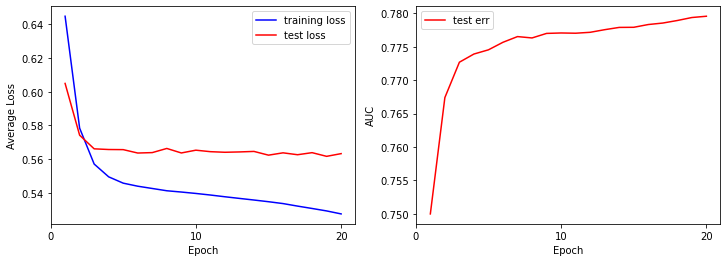

In [ ]:
fig, (loss_ax, err_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')
err_ax.plot(range(1,epochs+1), test_err, 'r', label='test err')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

err_ax.set_xticks(range(0, epochs+1, 10))
err_ax.set_xlabel('Epoch')
err_ax.set_ylabel('AUC')
err_ax.legend()

plt.show()

---

## 2. PyTorch로 FFM 구현하기

### <font color='#5F71F7'>과제 HOMEWORK (3)</font> 
### 2.1. `FFMLayer` 구현하기

- `FFMLayer`에서 구현할 부분 :

$$ \mathrm{FFMLayer} \left( \mathrm{x} \right) = \sum_{i=1}^{n} \sum_{j=i+1}^{n}{\left \langle \mathrm{v}_{i,f_j} \, , \mathrm{v}_{j,f_i} \right \rangle x_i x_j} \\ \qquad \qquad \quad = \sum_{i=1}^{n} \sum_{j=i+1}^{n}{\left \langle x_i \mathrm{v}_{i,f_j} \, , x_j \mathrm{v}_{j,f_i} \right \rangle}$$

- <font color=blue>참고 1)</font>
    <br> 수식은 입력값($x$)을 중심으로 전개되어 있지만, 이를 필드($f$) 중심으로 전개하면 아래와 같다. (필드의 총 개수: $F$)

$$\sum_{i=1}^{n} \sum_{j=i+1}^{n}{\left \langle x_i \mathrm{v}_{i,f_j} , x_j \mathrm{v}_{j,f_i}  \right \rangle} = \sum_{f=1}^{F} \sum_{g=i+1}^{F}{\left \langle x_{i_g} \mathrm{v}_{i_g,f} \, , x_{i_f} \mathrm{v}_{i_f,g}  \right \rangle}$$

- <font color=blue>참고 2)</font>
    <br> $x_i \mathrm{v}_{i,f}$는 필드 $f$에 대해 $x_{i}$를 $k$개의 factorization 차원으로 임베딩한 것으로 이해할 수 있다.
    <br> 따라서, `nn.Embedding()`을 통해 내적 안에 사용될 값을 쉽게 계산할 수 있다.
    <br>

- <font color=red>주의)</font>
    <br> `forward()` 함수에 들어가는 입력값 `x`의 형태:
    - [3,1,0,6] $\Rightarrow$ (X)
    - [0,0,0,1, 0,1, 1,0,0, 0,0,0,0,0,0,1,0,0] $\Rightarrow$ (X)
    - [3,5,6,15] $\Rightarrow$ (O)
        - `FieldAwareFM` 모델에서 이미 변환되므로 `FFMLayer`에서는 이를 가정하고 코딩해야 함
    <br>
    

In [101]:
class FFMLayer(nn.Module):
    def __init__(self, field_dims, factor_dim):
        '''
        Parameter
            field_dims: List of field dimensions 
                        The sum become the entire dimension of input (in sparse feature)
                        The length become the number of fields
            factor_dim: Factorization dimension
        '''
        super().__init__()
        self.num_fields = len(field_dims)
        self.input_dim = sum(field_dims)
        self.embedding = nn.ModuleList([
            # FILL HERE : Fill in the places `None` with                                      #
            #             either `factorization_dim`, `self.num_fields`, or `self.input_dim`. #
            nn.Embedding(
                self.input_dim, factor_dim
            ) for _ in range(self.num_fields)
        ])

    def forward(self, x):
        '''
        Parameter
            x: Long tensor of size "(batch_size, num_fields)"
               Each value of variable is an index calculated including the dimensions up to the previous variable.
               for instance, [gender:male, age:20, is_student:True] 
                             -> [1,0, 0,1,0,0,0,0, 0,1] in one-hot encoding
                             -> x = [0,3,9].
        Return
            y: Float tensor of size "(batch_size)"
        '''
        
        xv = [self.embedding[f](x) for f in range(self.num_fields)]
        
        y = list()
        for f in range(self.num_fields):
            for g in range(f + 1, self.num_fields):
                y.append(xv[f][:, g] *  xv[g][:, f])
        y = torch.stack(y, dim=1)
        
        return torch.sum(y, dim=(2,1))

### <font color='#5F71F7'>과제 HOMEWORK (4)</font> 
### 2.2. `FFMLayer`를 활용하여 `FieldAwareFM` 모델 구현하기

- `FieldAwareFM`에서 구현할 부분 :
$$\hat{y}(\mathrm{x}) = w_0 + \sum_{i=1}^{n}{\mathrm{w}_i x_i} + \mathrm{FFMLayer}\left( \mathrm{x} \right) \\ \, = \mathrm{Linear}\left( \mathrm{x} \right) + \mathrm{FFMLayer}\left( \mathrm{x} \right)$$
 
        
- <font color=red>주의)</font>
    <br> 각 레이어마다 사용되는 입력값의 형태가 다름
    - `self.linear()` : `x_multihot` 사용 ( ex. [0,0,0,1, 0,1, 1,0,0, 0,0,0,0,0,0,1,0,0] )
    - `self.ffm()` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : `x` 사용 ( ex. [3, 5, 6, 15] )
    <br>

In [113]:

class FieldAwareFM(nn.Module):
    def __init__(self, field_dims, factor_dim):
        '''
        Parameter
            field_dims: List of field dimensions
            factor_dim: Factorization dimension
        '''
        super().__init__()
        self.input_dim = sum(field_dims)
        self.encoding_dims = np.concatenate([[0], np.cumsum(field_dims)[:-1]])
        self.linear = nn.Linear(self.input_dim, 1, bias=True) # FILL HERE : Fill in the places `None` #
        self.ffm = FFMLayer(field_dims, factor_dim) # FILL HERE : Fill in the places `None` #
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, FFMLayer):
                nn.init.normal_(m.v, 0, 0.01)

    def forward(self, x):
        '''
        Parameter
            x: Long tensor of size "(batch_size, num_fields)"
                x_multihot: Multi-hot coding of x. size "(batch_size, self.input_dim)"
        
        Return
            y: Float tensor of size "(batch_size)"
        '''
        
        x = x + x.new_tensor(self.encoding_dims).unsqueeze(0)
        
        x_multihot = torch.zeros(x.size(0), self.input_dim, device=device).scatter_(1, x, 1.)
        
        y = self.linear(x_multihot).squeeze(1) + self.ffm(x) # FILL HERE : Use `self.linear()` and `self.ffm()` #
        

        return y
        

### 2.3. FFM 모델 학습하기

- `task = 'reg'` : 회귀 문제
    - 학습 : MSE를 손실함수로 사용
    - 검증 : MAE 사용


- `task = 'clf'` : 이진 분류 문제
    - 학습 : Cross Entropy를 손실 함수로 사용 ( 모델의 리턴 값이 logit이므로 `nn.BCEWithLogitsLoss()`를 사용 )
    - 검증 : AUC 사용


- 1.3.에서 선언한 `train_and_test()` 함수 그대로 사용

#### 2.3.1. 하이퍼파라미터 설정 & 학습에 필요한 인스턴스 선언 및 초기화

In [114]:
######## Hyperparameter ########

batch_size = 256
data_shuffle = True
task = 'reg'
factorization_dim = 8
epochs = 20
learning_rate = 0.001
gpu_idx = 0

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

train_dataloader_ffm = DataLoader(train_dataset_ffm, batch_size=batch_size, shuffle=data_shuffle)
test_dataloader_ffm = DataLoader(test_dataset_ffm, batch_size=batch_size, shuffle=data_shuffle)

field_dims = list(len(col_dict[k]) for k in col_dict)
model = FieldAwareFM(field_dims, factorization_dim).to(device)

loss_fn = nn.MSELoss().to(device) if (task == 'reg') else nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001, amsgrad=True)

#### 2.3.2. 학습 진행

In [115]:
train_loss, test_err, test_loss = train_and_test(train_dataloader_ffm, test_dataloader_ffm, 
                                                 model, loss_fn, optimizer, epochs, task)
# 2 epoch에 3분 15초
# 20 epoch 30분

loss: 0.000337  [409600/4123576]
loss: 0.000185  [435200/4123576]
loss: 0.000536  [460800/4123576]
loss: 0.002635  [486400/4123576]
loss: 0.000505  [512000/4123576]
loss: 0.000327  [537600/4123576]
loss: 0.000349  [563200/4123576]
loss: 0.000349  [588800/4123576]
loss: 0.000466  [614400/4123576]
loss: 0.000712  [640000/4123576]
loss: 0.000346  [665600/4123576]
loss: 0.000281  [691200/4123576]
loss: 0.001007  [716800/4123576]
loss: 0.000296  [742400/4123576]
loss: 0.000234  [768000/4123576]
loss: 0.000585  [793600/4123576]
loss: 0.000558  [819200/4123576]
loss: 0.000214  [844800/4123576]
loss: 0.000457  [870400/4123576]
loss: 0.000380  [896000/4123576]
loss: 0.000188  [921600/4123576]
loss: 0.000195  [947200/4123576]
loss: 0.000390  [972800/4123576]
loss: 0.000456  [998400/4123576]
loss: 0.000543  [1024000/4123576]
loss: 0.000226  [1049600/4123576]
loss: 0.000697  [1075200/4123576]
loss: 0.000370  [1100800/4123576]
loss: 0.000289  [1126400/4123576]
loss: 0.002339  [1152000/4123576]
loss

#### 2.3.3. 학습 곡선 도식화

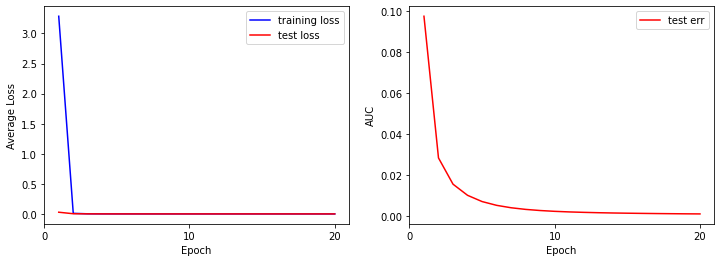

In [116]:
fig, (loss_ax, err_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')
err_ax.plot(range(1,epochs+1), test_err, 'r', label='test err')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

err_ax.set_xticks(range(0, epochs+1, 10))
err_ax.set_xlabel('Epoch')
err_ax.set_ylabel('AUC')
err_ax.legend()

plt.show()

In [ ]:
fig, (loss_ax, err_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')
err_ax.plot(range(1,epochs+1), test_err, 'r', label='test err')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

err_ax.set_xticks(range(0, epochs+1, 10))
err_ax.set_xlabel('Epoch')
err_ax.set_ylabel('AUC')
err_ax.legend()

plt.show()

In [118]:
test_loss

[0.02815870982175038,
 0.003110633521075525,
 0.0010738092954697249,
 0.0005055218072142418,
 0.0002724135024390394,
 0.00016820219968485226,
 0.00010950215316368246,
 7.754765901056532e-05,
 5.712300289401864e-05,
 4.411491469512112e-05,
 3.5309855382854456e-05,
 2.873514440539389e-05,
 2.3981307604711295e-05,
 2.0128841833290422e-05,
 1.744901206596685e-05,
 1.516704483355641e-05,
 1.323172152323248e-05,
 1.1759747905067339e-05,
 1.0433603441369625e-05,
 9.57778163985481e-06]

# Inference

In [124]:
torch.save(model, "FFM.pt")
model=torch.load('FFM.pt')
# model.eval()

rating = torch.tensor(()).to(device) # empty tensor

In [125]:
neg=pd.read_csv(os.path.join(base_path,'neg_sample_final.csv'))
print('neg.shape', neg.shape)
print('*'*20,'neg.info()','*'*20)
print(neg.info())
print('*'*20,'neg.head()','*'*20)
print(neg.head())

neg.shape (94672810, 2)
******************** neg.info() ********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94672810 entries, 0 to 94672809
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
dtypes: int64(2)
memory usage: 1.4 GB
None
******************** neg.head() ********************
   user  item
0    11     2
1    11     3
2    11  8195
3    11     5
4    11     6


In [129]:
with torch.no_grad():
    for batch in range(len(neg)):
        x = neg.iloc[batch,:] # (batch_size, attr_list)
        print ("[DEBUG] model input x-----")
        print (x)
        print ("--------------------------")
        output = model(x) #[B] ///     item[idx] = x 에 대한 확률 output[idx]
        # idx = torch.where(output >= 0.5)[0]
        
        # x = x.index_select(0,idx)
        # output = output.index_select(0,idx)
        
        preds = torch.cat((x,output.unsqueeze(1)),dim =1) # [B , 4]
        rating = torch.cat((rating, preds.cpu()), dim = 0)

outputs = rating.numpy()

[DEBUG] model input x-----
user    11
item     2
Name: 0, dtype: int64
--------------------------


TypeError: 'collections.OrderedDict' object is not callable

In [ ]:
info = []
#-- Select Top 10 items
print("[INFO] Select Top 10 Items..")
for user_id in range(31360):
    idx = np.where(outputs[:,0].astype(int) == user_id)
    user_rating = outputs[idx[0]]
    output_best10_idx = np.argpartition(user_rating[:,-1], -10)[-10:]
    output_best10 = user_rating[output_best10_idx,1]
    
    user, movie_list =  neg.decode_offset(user_id, output_best10)
    for item in movie_list:
        info.append([user,item])
    
info = pd.DataFrame(info, columns=['user','item'])
info.to_csv("./submission.csv",index=False)
print("Inference Done!")